In [87]:
import re
import unicodedata
from typing import List

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import spacy
nlp = spacy.load("en_core_web_sm")

In [88]:
class TextPreprocessor:
    """
    Finance-aware text preprocessing pipeline.
    Deterministic, conservative, and sentiment-safe.
    """

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

        # Base English stopwords
        base_stopwords = set(stopwords.words("english"))

        # Words we explicitly KEEP because they carry financial meaning
        financial_keep = {
            "up", "down", "over", "under", "above", "below",
            "beat", "miss", "fall", "rise", "growth", "decline",
            "gain", "loss", "guidance"
        }

        self.stopwords = base_stopwords - financial_keep

    # --------------------------------------------------
    # Normalization
    # --------------------------------------------------
    def normalize(self, text: str) -> str:
        # Unicode normalization
        text = unicodedata.normalize("NFKD", text)

        # Expand simple contractions
        contractions = {
            "n't": " not",
            "'re": " are",
            "'s": " is",
            "'d": " would",
            "'ll": " will",
            "'t": " not",
            "'ve": " have",
            "'m": " am"
        }

        for k, v in contractions.items():
            text = text.replace(k, v)

        return text.lower()

    # --------------------------------------------------
    # Tokenization
    # --------------------------------------------------
    def tokenize(self, text: str) -> List[str]:
        """
        Tokenizes text while preserving:
        - numbers
        - percentages
        - alphanumeric tokens (q4, iphone15)
        """
        pattern = r"""
            \d+\.\d+%? |      # decimals, optional %
            \d+%? |           # integers, optional %
            [a-zA-Z]+\d+ |    # words followed by numbers
            \d+[a-zA-Z]+ |    # numbers followed by words
            [a-zA-Z]+         # pure words
        """
        return re.findall(pattern, text, re.VERBOSE)

    # --------------------------------------------------
    # Stopword removal
    # --------------------------------------------------
    def remove_stopwords(self, tokens: List[str]) -> List[str]:
        return [t for t in tokens if t not in self.stopwords]

    # --------------------------------------------------
    # Lemmatization (POS-aware)
    # --------------------------------------------------
    def lemmatize(self, tokens: List[str]) -> List[str]:
        pos_tags = pos_tag(tokens)
    
        def map_pos(tag):
            if tag.startswith("J"):
                return wordnet.ADJ
            elif tag.startswith("V"):
                return wordnet.VERB
            elif tag.startswith("N"):
                return wordnet.NOUN
            elif tag.startswith("R"):
                return wordnet.ADV
            return None
    
        lemmatized = []
    
        for word, tag in pos_tags:
            wn_pos = map_pos(tag)
    
            # 1. POS-aware lemmatization
            if wn_pos:
                lemma = self.lemmatizer.lemmatize(word, wn_pos)
                morphy = wordnet.morphy(word, wn_pos)
            else:
                lemma = self.lemmatizer.lemmatize(word)
                morphy = None
    
            # 2. Verb fallback (ONLY if nothing changed)
            if lemma == word:
                verb_morph = wordnet.morphy(word, wordnet.VERB)
                if verb_morph:
                    lemma = verb_morph
    
            lemmatized.append(lemma)
    
        return lemmatized



    # --------------------------------------------------
    # Full pipeline
    # --------------------------------------------------
    def preprocess(self, text):
        doc = nlp(text)
        return [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop
            and token.is_alpha or token.like_num
        ]


In [89]:
tp = TextPreprocessor()

sentence = "Apple Inc. shares fell 2.5% amid concerns about iPhone 15 demand."
print(tp.preprocess(sentence))


['apple', 'share', 'fall', '2.5', 'amid', 'concern', 'iphone', '15', 'demand']


In [90]:
from typing import Dict
import numpy as np

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


In [91]:
FINANCIAL_LEXICON = {
    # positive
    "beat": 1.0,
    "growth": 0.8,
    "gain": 0.7,
    "profit": 0.9,
    "strong": 0.6,
    "upgrade": 0.8,
    "outperform": 1.0,

    # negative
    "miss": -1.0,
    "loss": -0.9,
    "decline": -0.8,
    "fall": -0.7,
    "weak": -0.6,
    "downgrade": -0.8,
    "underperform": -1.0,
}


In [92]:
class LexiconSentimentAnalyzer:
    """
    Multi-method sentiment analyzer for financial text.
    """

    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
        self.vader = SentimentIntensityAnalyzer()
        self.lexicon = FINANCIAL_LEXICON

    # -----------------------------
    # VADER (raw text)
    # -----------------------------
    def vader_sentiment(self, text: str) -> Dict:
        scores = self.vader.polarity_scores(text)
        compound = scores["compound"]

        label = "positive" if compound > 0.05 else \
                "negative" if compound < -0.05 else "neutral"

        return {"compound": compound, "label": label}

    # -----------------------------
    # TextBlob (raw text)
    # -----------------------------
    def textblob_sentiment(self, text: str) -> Dict:
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity  # [-1, 1]

        label = "positive" if polarity > 0.1 else \
                "negative" if polarity < -0.1 else "neutral"

        return {"polarity": polarity, "label": label}

    # -----------------------------
    # Custom lexicon (tokens)
    # -----------------------------
    def custom_lexicon_sentiment(self, text: str) -> float:
        tokens = self.preprocessor.preprocess(text)

        scores = [
            self.lexicon[t] for t in tokens
            if t in self.lexicon
        ]

        if not scores:
            return 0.0

        # Normalize to [-1, 1]
        return float(np.clip(np.mean(scores), -1.0, 1.0))

    # -----------------------------
    # Ensemble
    # -----------------------------
    def analyze(self, text: str) -> Dict:
        vader = self.vader_sentiment(text)
        textblob = self.textblob_sentiment(text)
        custom = self.custom_lexicon_sentiment(text)

        ensemble_score = np.mean([
            vader["compound"],
            textblob["polarity"],
            custom
        ])

        label = "positive" if ensemble_score > 0.2 else \
                "negative" if ensemble_score < -0.2 else "neutral"

        confidence = abs(ensemble_score)

        return {
            "text": text,
            "vader": vader,
            "textblob": textblob,
            "custom_score": custom,
            "ensemble_score": ensemble_score,
            "label": label,
            "confidence": confidence
        }


In [93]:
lsa = LexiconSentimentAnalyzer(tp)

sentence = "Excellent earnings beat expectations"
result = lsa.analyze(sentence)

result


{'text': 'Excellent earnings beat expectations',
 'vader': {'compound': 0.5719, 'label': 'positive'},
 'textblob': {'polarity': 1.0, 'label': 'positive'},
 'custom_score': 1.0,
 'ensemble_score': 0.8573,
 'label': 'positive',
 'confidence': 0.8573}

In [94]:
lsa.analyze("Company reported earnings")
lsa.analyze("Company missed earnings expectations")
lsa.analyze("Revenue was flat year over year")


{'text': 'Revenue was flat year over year',
 'vader': {'compound': 0.0, 'label': 'neutral'},
 'textblob': {'polarity': -0.025, 'label': 'neutral'},
 'custom_score': 0.0,
 'ensemble_score': -0.008333333333333333,
 'label': 'neutral',
 'confidence': 0.008333333333333333}

In [95]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

print("Path to dataset files:", path)

Path to dataset files: /Users/dilipkumar/.cache/kagglehub/datasets/ankurzing/sentiment-analysis-for-financial-news/versions/5


In [96]:
import os
import pandas as pd

file_path = os.path.join(path, "all-data.csv")

df = pd.read_csv(
    file_path,
    header=None,
    encoding="latin-1",
    names=["label", "sentence"]
)

df.head()


,label,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [97]:
df["sentence"] = df["sentence"].astype(str).str.strip()
df["label"] = df["label"].astype(str).str.strip()


In [98]:
from tqdm import tqdm
tqdm.pandas()

df["predicted_label"] = df["sentence"].progress_apply(
    lambda x: lsa.analyze(x)["label"]
)


100%|██████████████████████████████████████████████████████████████████████████████| 4846/4846 [00:44<00:00, 109.52it/s]


In [99]:
from sklearn.metrics import accuracy_score, classification_report

y_true = df["label"]
y_pred = df["predicted_label"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=3))


Accuracy: 0.6324803962030541
              precision    recall  f1-score   support

    negative      0.497     0.164     0.247       604
     neutral      0.678     0.837     0.749      2879
    positive      0.508     0.408     0.453      1363

    accuracy                          0.632      4846
   macro avg      0.561     0.470     0.483      4846
weighted avg      0.608     0.632     0.603      4846



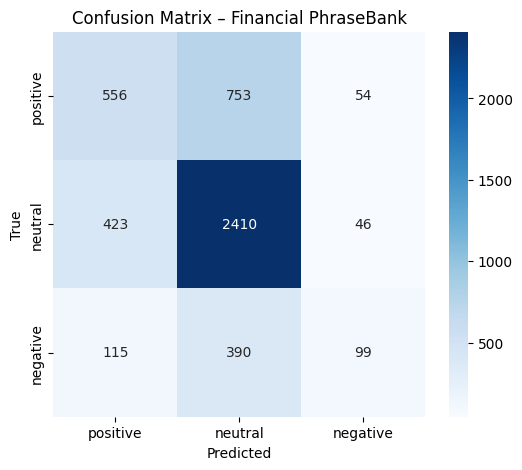

In [100]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Financial PhraseBank")
plt.show()


In [102]:
df["sentence"].str.contains(r"\bfall\b", case=False).sum()


14